In [1]:
import numpy as np
import gymnasium as gym
from IPython.display import clear_output
import os

ModuleNotFoundError: No module named 'gymnasium'

# Evolving a simple neural network

This is an example problem, a task similar to Assignment 1, however much simpler. It's not obligatory, but recommended for self-study.

The problem at hand the Mountaincar Problem, a typical benchmark in reinforcement learning - a car is standing on a slope of the mountain, it needs to get uphill. At any given time, we get the information about the car's position and velocity, and we need to ddecide between three actions - accelerate left, accelerate right or don't accelerate.

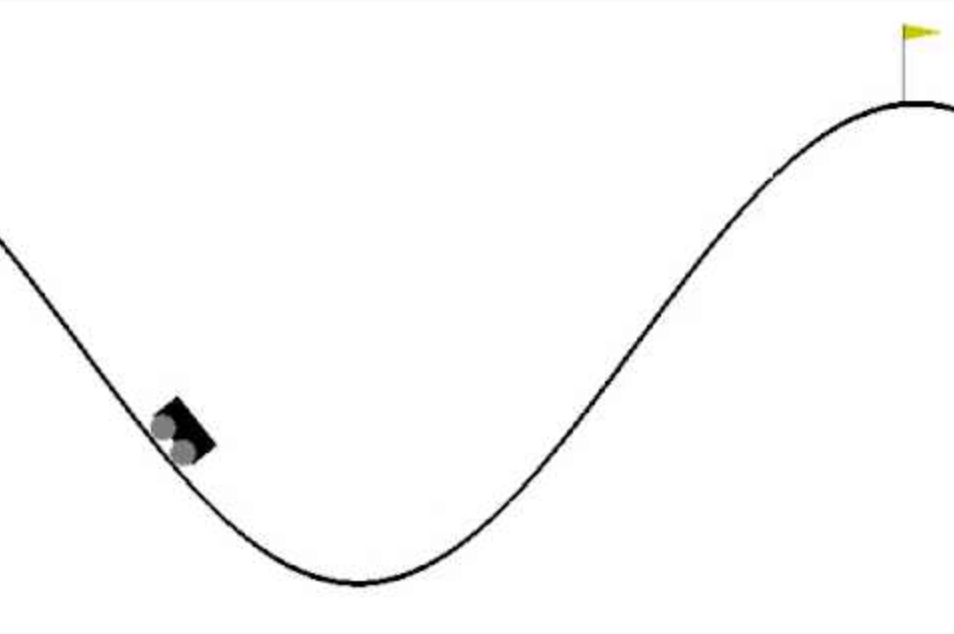


The goal is to evolve a vector of weights of a simple neural network (a perceptron), which encodes the agent's response pattern to the inputs from the environment. Assignment 1 is similar on a conceptual level, however the enviornment and the network controlling the agent are more complex.

In this notebook we will evolve a simple single layer perceptron while walking through all components of a genetic algorithm:

<ul>
<li>representation (definition of individuals)</li>
<li>evaluation function (or fitness function)</li>
<li>population</li>
<li>parent selection mechanism</li>
<li>variation operators, recombination and mutation</li>
<li>survivor selection mechanism (replacement)</li>
</ul>

## Representation

Solution representation is highly dependent on the problem. In this case a simple control task Mountain Car from openAI gym.
The example below shows an agent taking random actions.

In [ ]:

env = gym.make('MountainCar-v0', render_mode='human')

observation = env.reset()

for _ in range(200):
    action = env.action_space.sample ()
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()

    if terminated:
        env.reset()

env.close()

The goal of our agent is to reach the flag on top of the hill. To achieve this it must make use of the observations of the environment to decide the correct action.

Our first step is to discover the nature and scope of both these variables.

In [ ]:
# Observation and action space
obs_space = env.observation_space
action_space = env.action_space
print("The observation space: {}".format(obs_space))
print("The action space: {}".format(action_space))

From this we can see that the observation space is a two-dimensional continuous vector. The values will represent the position and velocity of the cart.

As action the agent has a choice of 3 discrete options: applying force in either of the directions or applying no force.

A possible mapping from observation to action is a single-layer perceptron with an output node for every distinct action. After activation we can simply take the action with the highest corresponding output.

In [ ]:
class Perceptron:
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

    def activation(self, input, weights):
        x = np.dot(input, weights.reshape (self.n_inputs, self.n_outputs))
        return np.argmax(x)

This brings us to the representation of an individual solution. Remember that we only want to store necessary information into the genotype. So, since the structure of our network will remain static, the only things that are subject to change are the weight values. This way we can compactly store our individuals as an array of weights.

Let's take a look how this all comes together.

In [ ]:
individual = np.array ([0.1, -0.1, 0, 0.5, -0.5, 0.3], dtype=np.float64)

network = Perceptron (2, 3)


env = gym.make("MountainCar-v0", render_mode="human")

observation, info = env.reset()

for _ in range(200):
    action = network.activation (observation, individual)

    observation, reward, terminated, truncated, info = env.step(action)
    env.render()

    if terminated:
        break

env.close()

Okay that seems worse than taking random actions but that is where our algorithm will come into play.

Although in this case the solution is fairly simple so feel free to play around with the weights to see if you can find a good solution.

## Evaluation

Of course we need a way to quantify an individual's performance. Luckily gym already provides a reward signal on each timestep so we can sum these and return the total. We also remove the render call to speed up the process significantly.

In [ ]:
def evaluate(weights, net, env):
    observation, info = env.reset()
    total_reward = 0

    for _ in range(1000):
        action = net.activation(observation, weights)
        observation, reward, terminated, truncated, info = env.step(action)

        total_reward += reward

        if terminated:
            observation = env.reset()
            break

    return total_reward


env = gym.make("MountainCar-v0")
print (evaluate (individual, network, env))
env.close()

## Population

Let's create a population. For this we only need to define some bounds for our weight values. In this case we generate the values over an uniform distribution. we can be more efficient by storing everything in a two-dimensional array with shape N_Population x N_Weights.

In [ ]:
def initialize_population(population_size, lower, upper, n_weights = 6):
    return np.random.uniform(lower, upper, (population_size, n_weights))

pop = initialize_population(10, -2, 2)
pop

Of course we also want a function to evaluate the entire population. Since in many cases you will be dealing with a noisy environment, let's also add a number of evaluations parameter where we take the mean of all evaluations.

In [ ]:
def evaluate_population(pop, number_of_evaluations, net, env):
    population_fitness = np.zeros(pop.shape[0])

    for i in range (pop.shape [0]):
        population_fitness[i] = np.mean ([evaluate (pop[i], net, env) for _ in range (number_of_evaluations)])

    return population_fitness

env = gym.make("MountainCar-v0")
print (evaluate_population(pop, 10, network, env))
env.close()

## Parent Selection

Now we have a population and a way to evaluate it, we can decide which individuals are fit to be a parent. Often this is done in a stochastic manner but influenced by the individuals fitness score.

We want to perform crossover later so we are picking parents in pairs of two.

Fitness is recalculated by adding the lowest score to make the value range from 0 upwards. A smoothing factor is added to give the worst individual still a chance to be picked and preventing a divide by 0 in case all individuals have the same fitness.

In [ ]:
def parent_selection(pop, pop_fit, n_parents, smoothing = 1):
    fitness  = pop_fit + smoothing - np.min(pop_fit)

    # Fitness proportional selection probability
    fps = fitness / np.sum (fitness)

    # make a random selection of indices
    parent_indices = np.random.choice (np.arange(0,pop.shape[0]), (n_parents,2), p=fps)
    return pop [parent_indices]

## Variation

The chosen parents create new individuals through crossover. The below example shows the simplest form of crossover where every individual weight is set randomly to one of the parents.

In [ ]:
def crossover(parents):
    parentsA, parentsB = np.hsplit (parents,2)
    roll = np.random.uniform (size = parentsA.shape)
    offspring = parentsA * (roll >= 0.5) + parentsB * (roll < 0.5)
    # squeeze to get rid of the extra dimension created during parent selecting
    return np.squeeze(offspring,1)

Mutation introduces additional variation, in this case we apply a Gaussian mutation on all weights. The Sigma parameter controls the standard deviation with which we can set the average scale of the mutations.

Finally we need to ensure that weight values don't go out of bounds.

In [ ]:
def mutate(pop,min_value,max_value, sigma):
    mutation = np.random.normal(0, sigma, size=pop.shape)
    new_pop = pop + mutation
    new_pop[new_pop>max_value] = max_value
    new_pop[new_pop<min_value] = min_value
    return new_pop

## Survivor Selection

After offspring has been generated we need to decide which individuals stay in the population. In contrast to parent selection this is often done deterministically. The example simply picks the top $populationSize$ individuals.

To prevent having to reevaluate we also keep the fitness score.

In [ ]:
def survivor_selection(pop, pop_fit, n_pop):
    best_fit_indices = np.argsort(pop_fit * -1) # -1 since we are maximizing
    survivor_indices = best_fit_indices [:n_pop]
    return pop [survivor_indices], pop_fit[survivor_indices]

## Full Algorithm

In [ ]:
# Parameters
population_size = 50
n_evaluations = 3
n_offspring = 50
weight_upper_bound = 2
weight_lower_bound = -2
mutation_sigma = .1
generations = 10

# Initialize environment, network and population. Perform an initial evaluation
env = gym.make("MountainCar-v0")
net = Perceptron (2, 3)
pop = initialize_population(population_size, weight_lower_bound, weight_upper_bound)
pop_fit = evaluate_population(pop, n_evaluations, net, env)

for i in range (generations):
    parents = parent_selection(pop, pop_fit, n_offspring)
    offspring = crossover (parents)
    offspring = mutate (offspring, weight_lower_bound, weight_upper_bound, mutation_sigma)

    offspring_fit = evaluate_population(offspring, n_evaluations, net, env)

    # concatenating to form a new population
    pop = np.vstack((pop,offspring))
    pop_fit = np.concatenate([pop_fit,offspring_fit])

    pop, pop_fit = survivor_selection(pop, pop_fit, population_size)

    print (f"Gen {i} - Best: {np.max (pop_fit)} - Mean: {np.mean(pop_fit)}")
    clear_output(wait=True)
env.close()

## Notes

We can take a look at the winner.

In [ ]:
individual = pop [np.argmax(pop_fit)]

network = Perceptron (2, 3)


env = gym.make("MountainCar-v0", render_mode="human")

observation, info = env.reset()

for _ in range(1000):
    action = network.activation (observation, individual)
    observation, reward, done, truncated, info = env.step(action)
    env.render()

    if done:
        break

env.close()

If you did not change the parameters there's a good chance that the best found network does not succeed in the task every single time. This could have been caused by many things:

Did we not evaluate enough times and did this solution get lucky?

Did our search get stuck in a local optimum?

Does the algorithm just need more generations to run or a larger population size?

In the end it will be up to you to find the answers to these questions. Usually you don't get the answers by running your algorithm just once. You need multiple runs with the same parameters before comfortably making statements about your approach. For this you want to collect as much data from your runs as possible. Below an example for saving data during the run. The class can be extended of course, think about things like measuring diversity within your population during the course of a run.



In [ ]:
class DataGatherer:

    def __init__(self, name):
        self.name = name
        self.mean_fitness = np.array ([])
        self.best_fitness = np.array ([])
        self.generations = np.array ([])
        self.stats = []

        if not os.path.exists(name):
            os.mkdir(name)
            os.mkdir(name+"/best")

    def gather(self, pop, pop_fit, gen):
        self.mean_fitness = np.concatenate([self.mean_fitness, [np.mean (pop_fit)]])
        self.best_fitness = np.concatenate([self.best_fitness, [np.max (pop_fit)]])
        self.generations = np.concatenate([self.generations, [gen]])

        self.stats = np.stack([self.generations, self.mean_fitness,self.best_fitness])

        np.savetxt(f"{self.name}/stats.out", self.stats.T, delimiter=',',fmt='%1.2e')
        np.savetxt(f"{self.name}/best/{gen}.out", pop [np.argmax(pop_fit)],  delimiter=',',fmt='%1.2e')



In [ ]:
# Parameters
population_size = 100
n_evaluations = 3
n_offspring = 100
weight_upper_bound = 2
weight_lower_bound = -2
mutation_sigma = .1
generations = 10

# Initialize environment, network and population. Perform an initial evaluation
env = gym.make("MountainCar-v0")
net = Perceptron (2, 3)
pop = initialize_population(population_size, weight_lower_bound, weight_upper_bound)
pop_fit = evaluate_population(pop, n_evaluations, net, env)
data = DataGatherer ("simple_example") # think of a good naming convention

for gen in range (generations):
    parents = parent_selection(pop, pop_fit, n_offspring)
    offspring = crossover (parents)
    offspring = mutate (offspring, weight_lower_bound, weight_upper_bound, mutation_sigma)

    offspring_fit = evaluate_population(offspring, n_evaluations, net, env)

    # concatenating to form a new population
    pop = np.vstack((pop,offspring))
    pop_fit = np.concatenate([pop_fit,offspring_fit])

    pop, pop_fit = survivor_selection(pop, pop_fit, population_size)

    data.gather (pop, pop_fit, gen)
    print (f"Gen {gen} - Best: {np.max (pop_fit)} - Mean: {np.mean(pop_fit)}")
    clear_output(wait=True)

We can look at the data with for example plotly and pandas

In [ ]:
import plotly.express as px
import pandas as pd

In [ ]:
raw_data = np.loadtxt("simple_example/stats.out",delimiter=",")
data_plot = pd.DataFrame(raw_data, columns=["Generation", "Mean", "Best"])
px.line (data_plot, x="Generation", y=["Mean", "Best"], labels={"value": "Performance"})